# Exploratory Data Analysis

by  : Andreas Chandra \
date:21/03/2021

In [1]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
data_path = "../datasets"

In [3]:
files = list(filter(lambda x: x.endswith('.csv'), os.listdir(data_path)))
files

['df_41017.csv',
 'df_41040.csv',
 'df_41043.csv',
 'df_41048.csv',
 'df_41060.csv',
 'df_42002.csv',
 'df_42055.csv',
 'df_44014.csv',
 'df_44017.csv',
 'df_44020.csv',
 'df_46069.csv']

In [4]:
d_data = pd.read_csv(os.path.join(data_path, files[0]))

In [5]:
d_data.shape

(32100, 2)

In [6]:
d_data

,date,swh
0,2013-03-31 23:50:00,2.15
1,2013-04-01 00:50:00,2.18
2,2013-04-01 01:50:00,2.32
3,2013-04-01 02:50:00,2.47
4,2013-04-01 03:50:00,2.31
...,...,...
32095,2016-12-31 18:50:00,2.01
32096,2016-12-31 19:50:00,1.99
32097,2016-12-31 20:50:00,2.11
32098,2016-12-31 21:50:00,2.15


In [7]:
d_data.dtypes

date     object
swh     float64
dtype: object

In [8]:
d_data.date = pd.to_datetime(d_data.date)

In [9]:
len(d_data.date)

32100

In [10]:
# check whether there's non one-hour timeframe
checkNotOneHour = lambda i: (d_data.date[i+1]-d_data.date[i]).seconds/3600
notOneHour = [(i,d_data.date[i], checkNotOneHour(i)) for i in range(len(d_data.date)-1) if checkNotOneHour(i) != 1.0]
len(notOneHour)

326

In [11]:
pd.Series([difference[2] for difference in notOneHour]).value_counts()

2.000000     319
3.000000       3
1.083333       1
20.000000      1
5.000000       1
0.916667       1
dtype: int64

In [12]:
# get duration of the data
print(d_data.date.min(), d_data.date.max())
print(d_data.date.max() - d_data.date.min())

2013-03-31 23:50:00 2016-12-31 22:50:00
1370 days 23:00:00


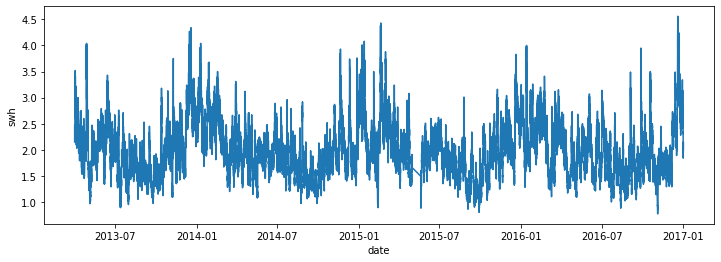

In [13]:
plt.figure(figsize=(12,4))
fig = sns.lineplot(x = 'date', y='swh', data=d_data)
# fig.figure.savefig("../figures/timeframe.png")

In [14]:
d_data.groupby(d_data.date.dt.date).count()

,date,swh
date,,
2013-03-31,1,1
2013-04-01,24,24
2013-04-02,24,24
2013-04-03,24,24
2013-04-04,24,24
...,...,...
2016-12-27,24,24
2016-12-28,24,24
2016-12-29,24,24


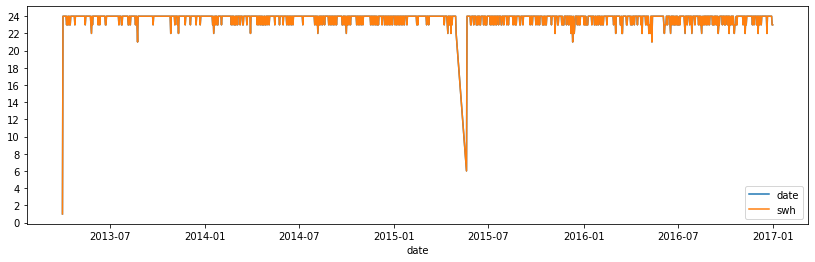

In [15]:
d_data.groupby(d_data.date.dt.date).count().plot(figsize=(14,4))
plt.yticks(list(range(0,25, 2)))
# plt.savefig('../figures/data_point_per_day.png')
plt.show()

### Restructure Dataset

In [16]:
date_range = pd.date_range(d_data.date.min(), d_data.date.max(), freq='1H')
date_range

DatetimeIndex(['2013-03-31 23:50:00', '2013-04-01 00:50:00',
               '2013-04-01 01:50:00', '2013-04-01 02:50:00',
               '2013-04-01 03:50:00', '2013-04-01 04:50:00',
               '2013-04-01 05:50:00', '2013-04-01 06:50:00',
               '2013-04-01 07:50:00', '2013-04-01 08:50:00',
               ...
               '2016-12-31 13:50:00', '2016-12-31 14:50:00',
               '2016-12-31 15:50:00', '2016-12-31 16:50:00',
               '2016-12-31 17:50:00', '2016-12-31 18:50:00',
               '2016-12-31 19:50:00', '2016-12-31 20:50:00',
               '2016-12-31 21:50:00', '2016-12-31 22:50:00'],
              dtype='datetime64[ns]', length=32904, freq='H')

In [17]:
d_data_fulltime = pd.DataFrame(date_range, columns=['date'])


In [18]:
d_data_fulltime = d_data_fulltime.merge(d_data, how='left', on='date')

In [19]:
d_data_fulltime.head()

,date,swh
0,2013-03-31 23:50:00,2.15
1,2013-04-01 00:50:00,2.18
2,2013-04-01 01:50:00,2.32
3,2013-04-01 02:50:00,2.47
4,2013-04-01 03:50:00,2.31


In [20]:
d_data_fulltime.isna().sum()

date      0
swh     805
dtype: int64

In [21]:
# fill nan values with interpolation

df_interpolate = d_data_fulltime.copy()
df_interpolate['swh'].interpolate(method='linear', inplace=True)

---

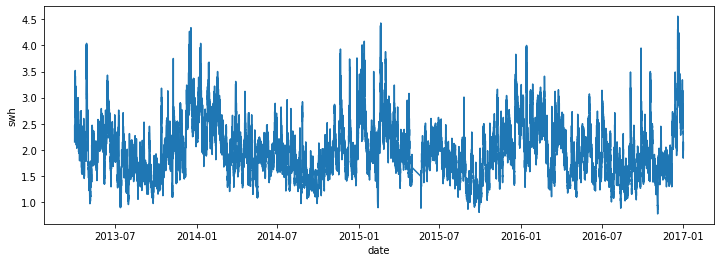

In [22]:
plt.figure(figsize=(12,4))
fig = sns.lineplot(x = 'date', y='swh', data=df_interpolate)
# fig.figure.savefig("../figures/timeframe.png")

Text(0.5, 1.0, 'Ocean Wave in 2016')

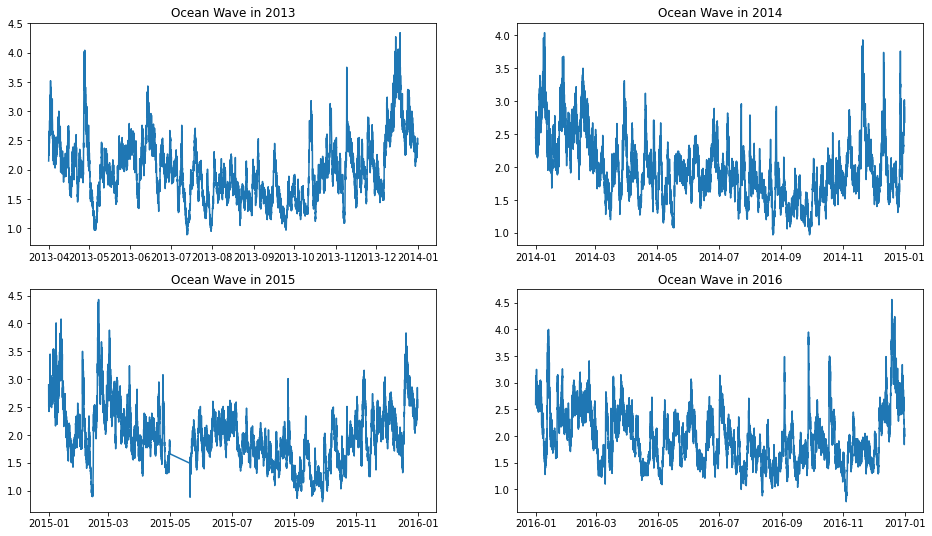

In [23]:
# each year plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,9))
ax1.plot('date', 'swh', data=df_interpolate[df_interpolate.date.dt.year==2013])
ax1.set_title('Ocean Wave in 2013')
ax2.plot('date', 'swh', data=df_interpolate[df_interpolate.date.dt.year==2014])
ax2.set_title('Ocean Wave in 2014')
ax3.plot('date', 'swh', data=df_interpolate[df_interpolate.date.dt.year==2015])
ax3.set_title('Ocean Wave in 2015')
ax4.plot('date', 'swh', data=df_interpolate[df_interpolate.date.dt.year==2016])
ax4.set_title('Ocean Wave in 2016')

In [24]:
# Augmented Dickey-Fuller test to determine stationarity

data = df_interpolate['swh']
adf = adfuller(data)
print(f'Test Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print('Critical Values:')
for key, value in adf[4].items():
	print(f'\t{key}: {value}')
    
# p-value is very low, so we reject the null hypothesis
# which indicates the data is stationary

Test Statistic: -11.478309993841364
p-value: 5.066829402042456e-21
Critical Values:
	1%: -3.430549062825808
	5%: -2.861627980668865
	10%: -2.5668168293763762


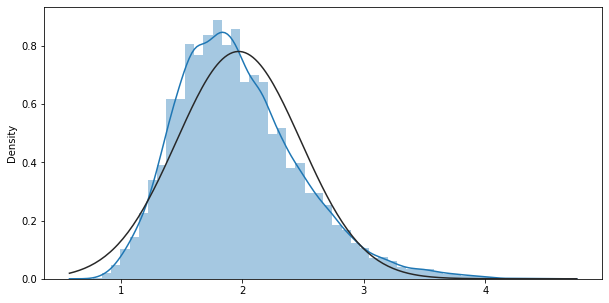

In [25]:
# distribution, seems a little bit right skewed, but we'll leave it

plt.figure(figsize=(10,5))
fig = sns.distplot(x=df_interpolate.swh, kde=True, fit=norm)

In [26]:
df_interpolate.swh.describe()

count    32904.000000
mean         1.970661
std          0.511044
min          0.770000
25%          1.600000
50%          1.900000
75%          2.260000
max          4.560000
Name: swh, dtype: float64

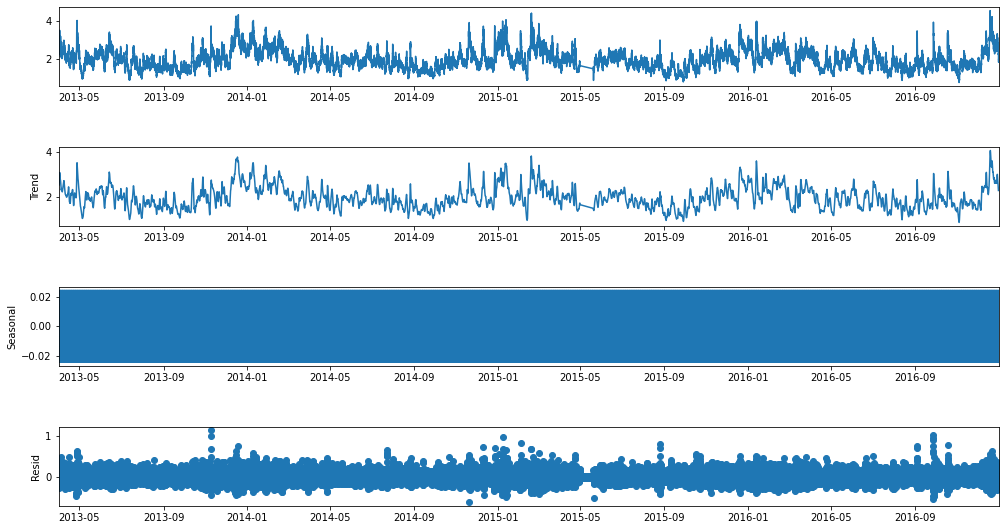

In [44]:
# seasonal decomposition
season = seasonal_decompose(df_interpolate.resample('1H', on='date').mean())
fig = season.plot()
fig.set_size_inches(16,8)
plt.show()

In [53]:
from datetime import datetime
datetime(1970, 1, 1).strftime('%Y-%d-%B')

'1970-01-January'

Autocorrelation & partial autocorrelation which gives us idea of how data points at different points in time are linearly related to one another as a function of their time difference.\
\
Rule of Thumb to determine lags by [Rob J Hyndman](https://robjhyndman.com/hyndsight/ljung-box-test/):
- For non-seasonal time series, use `h = min(10,T/5)` where `h = lags`, `T = length of time series`
- For seasonal time series, use `h = min(2m, T/5)` where `h = lags`, `T = length of time series`, `m = period of seasonality`

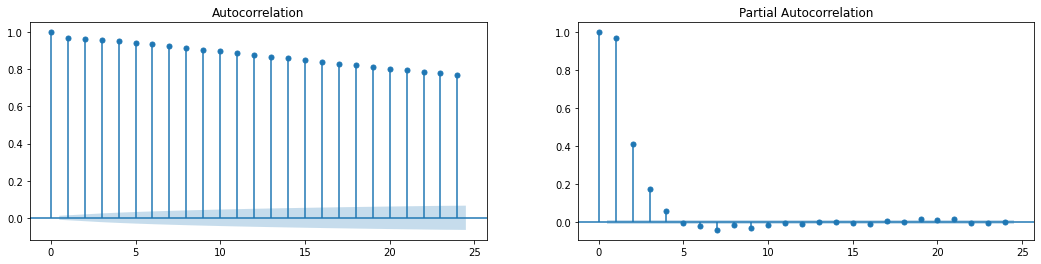

In [40]:
# autocorrelation & partial autocorrelation
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(df_interpolate.swh, lags=24, ax=ax1)
ax2 = plot_pacf(df_interpolate.swh, lags=24, ax=ax2)

In [29]:
# df_interpolate.to_csv("../data/clean/"+files[0], index=False)